## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import t

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [98]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [100]:
data['date'].dtypes

dtype('O')

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [101]:
data['date'] = pd.to_datetime(data['date'])
data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


In [102]:
data_a = data[data['group'] == 'A']
data_b = data[data['group'] == 'B']

In [103]:
def equal_period():
  if data_a['date'].min() == data_a['date'].min() and data_a['date'].max() == data_b['date'].max():
    return print(f"Длительность проведения тестирования в обеих группах равная.")
  else: return print(f"Длительность проведения тестирования в группах разная.")
  

In [104]:
equal_period()

Длительность проведения тестирования в обеих группах равная.


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [105]:
print(f"Число посещений сайта группы А : {data_a['user_id'].count()} чел.")
print(f"Число посещений сайта группы В : {data_b['user_id'].count()} чел.")
print(f"Суммарное количество покупок в группе А: {data_a['purchase'].sum()} шт.")
print(f"Суммарное количество покупок в группе B: {data_b['purchase'].sum()} шт.")
print(f"Cумма всех покупок в группе А: {data_a['price'].sum()/1000000} млн. руб.")
print(f"Cумма всех покупок в группе А: {data_b['price'].sum()/1000000} млн. руб.")

Число посещений сайта группы А : 147202 чел.
Число посещений сайта группы В : 147276 чел.
Суммарное количество покупок в группе А: 17723 шт.
Суммарное количество покупок в группе B: 17514 шт.
Cумма всех покупок в группе А: 1436.26 млн. руб.
Cумма всех покупок в группе А: 1554.1 млн. руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [106]:
user_intersection = data_a.merge(data_b.set_index('user_id'), on='user_id', how='inner' )
print(f"Количество пользователей, которые в процессе теста попали в обе группы: {user_intersection['user_id'].count()} чел.")
user_intersection = set(user_intersection['user_id'])

Количество пользователей, которые в процессе теста попали в обе группы: 1895 чел.


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [107]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

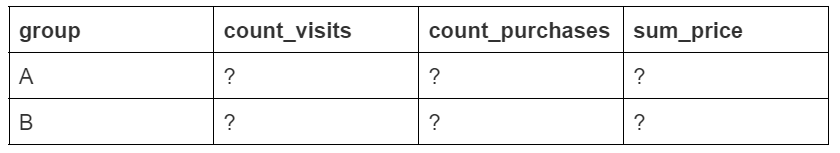
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [108]:
updated_df = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id':'count_visits', 'purchase': 'sum_purchases', 'price':'sum_price'})
updated_df

,group,count_visits,sum_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

## Выводы:
Анализируя данные из полученой нами таблицы, мы можем декларировать о сбалансированности выборок. Несмотря на то,что количество посещений посадочной страницы  варианта В немного больше, мы видим ,что количество покупок в варианте А заметно выше. Однако суммарная стоимость приобретенных туров больше в варианте В.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [109]:
updated_df['conversion'] = round((updated_df['sum_purchases'] / updated_df['count_visits'] * 100),2)
updated_df['mean_check'] = round(updated_df['sum_price'] / updated_df['sum_purchases'])
updated_df

,group,count_visits,sum_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

## Выводы:
Исследуя наш датафрейм мы видим,что вариант А имеет преимущественные показатели 
по количеству покупок, соответственно более высокий коэфициент конверсии. Однако
несмотря на это вариант В имеет более высокую сумму продаж, а соответственно и 
 средний чек.


## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [110]:
pivot_df= updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
pivot_df

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

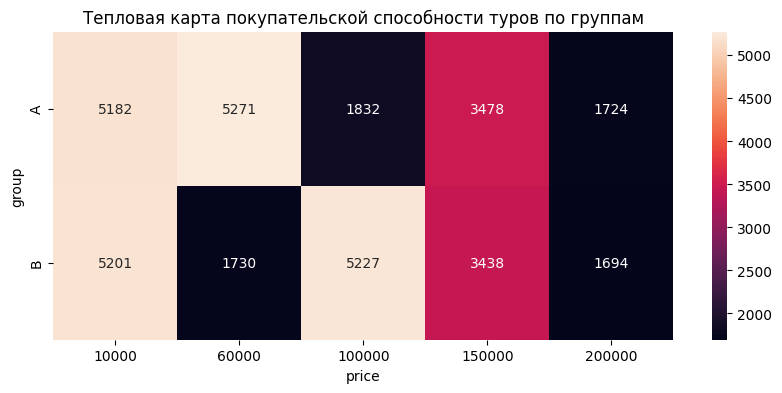

In [111]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot_df, fmt='.0f', annot=True);
ax.set_title('Тепловая карта покупательской способности туров по группам');

In [112]:
print(f"Количество проданных туров по цене - 60 000 рублей в группе А составляет: {pivot_df.loc['A', 60000]} шт.")
print(f"Количество проданных туров по цене - 60 000 рублей в группе В составляет: {pivot_df.loc['B', 60000]} шт.")

Количество проданных туров по цене - 60 000 рублей в группе А составляет: 5271 шт.
Количество проданных туров по цене - 60 000 рублей в группе В составляет: 1730 шт.


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

## Выводы:
Анализируя данные из таблицы pivot_df  мы видим, что покупательская способность участников группы А выше по турам стоимостью 60 т.руб. и ниже по турам стоимостью 
100 т.руб. Группа В имеет показатели обратные показателям группы А, т.е. количество туров стоимостьбю 100 т.руб гораздо больше, а количество туров стоимостью 60 т.руб.
гораздо меньше. Осталные показатели, туры стоимостью 10 т.руб., 150 т.руб. и 200 т.руб.,
имеют  приблизительно идентичные данные по обеим группам.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [113]:
daily_df = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id':'count_visits', 'purchase': 'sum_purchases', 'price':'sum_price'})
daily_df['conversion'] = round((daily_df['sum_purchases'] / daily_df['count_visits'] * 100),2)
daily_df['mean_check'] = round(daily_df['sum_price'] / daily_df['sum_purchases'])
daily_df.head()

,date,group,count_visits,sum_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


In [114]:
daily_day_df =daily_df[daily_df['date'] == '2021-01-03']
print(f"Конверсия 3 января 2021 года в группе А составляет: {daily_day_df.iloc[0,5]} %")
print(f"Конверсия 3 января 2021 года в группе А составляет: {daily_day_df.iloc[1,5]} %")
print(f"Срелний чек 3 января 2021 года в группе А составляет: {daily_day_df.iloc[0,6]} руб.")
print(f"Средний чек 3 января 2021 года в группе А составляет: {daily_day_df.iloc[1,6]} руб.")

Конверсия 3 января 2021 года в группе А составляет: 11.34 %
Конверсия 3 января 2021 года в группе А составляет: 11.39 %
Срелний чек 3 января 2021 года в группе А составляет: 82888.0 руб.
Средний чек 3 января 2021 года в группе А составляет: 87480.0 руб.


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [115]:
# вычисляем кумулятивные сумму по признакам  dataframe
daily_df['cum_count_visits'] = daily_df.groupby(['group'])['count_visits'].cumsum()
daily_df['cum_sum_purchases'] = daily_df.groupby(['group'])['sum_purchases'].cumsum()
daily_df['cum_sum_price'] = daily_df.groupby(['group'])['sum_price'].cumsum()
daily_df['cum_conversion'] = round((daily_df['cum_sum_purchases'] / daily_df['cum_count_visits'] * 100),2)
daily_df['cum_mean_check'] = round(daily_df['cum_sum_price'] / daily_df['cum_sum_purchases'])
daily_df.head()

,date,group,count_visits,sum_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_sum_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.71,82575.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.59,87006.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.90,81668.0


In [116]:
daily_day_df = daily_df[daily_df['date'] == '2021-01-20']
print(f"Кумулятивная конверсия в группе В на 2021-01-20 составляет: {daily_day_df.iloc[1,10]} %")
daily_day_df = daily_df[daily_df['date'] == '2021-01-12']
print(f"Кумулятивный средний чек в группе А на 2021-01-12 составляет: {daily_day_df.iloc[0,11]} руб.")

Кумулятивная конверсия в группе В на 2021-01-20 составляет: 11.9 %
Кумулятивный средний чек в группе А на 2021-01-12 составляет: 81492.0 руб.


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

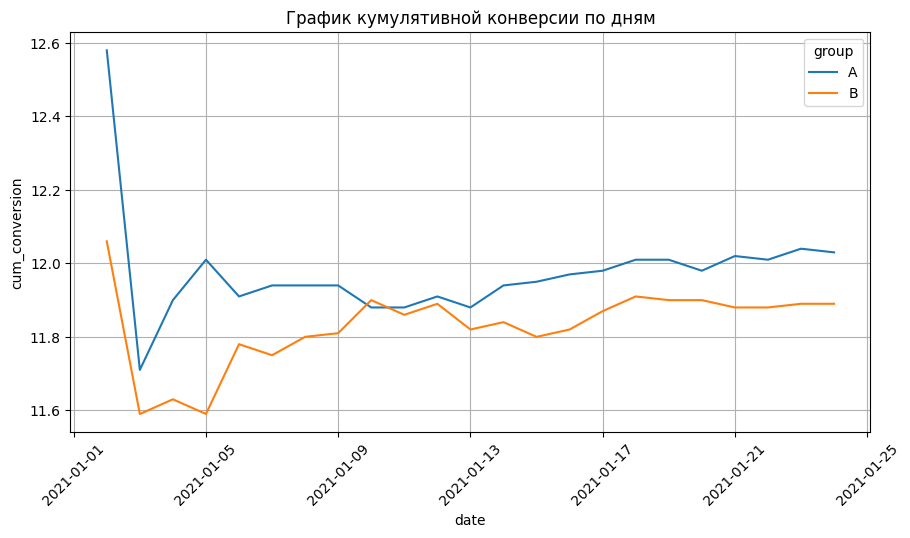

In [117]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_df,
    x='date',
    y='cum_conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

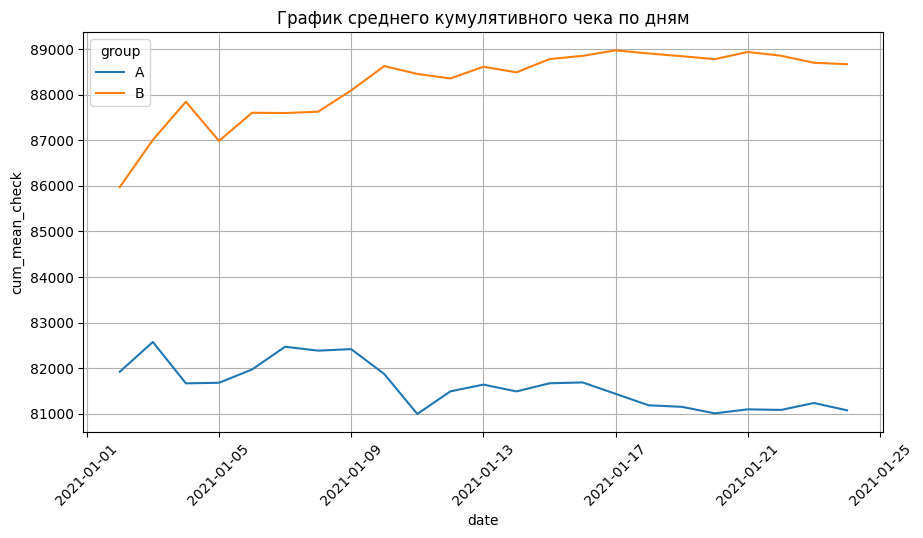

In [118]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_df,
    x='date',
    y='cum_mean_check',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График среднего кумулятивного чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

## Выводы:
Анализируя построенные графики проведенного А/В теста мы видим, что используемые метрики
(конверсии и среднего чека) начиная с 13 января 2021г. стабилизировались во времени.Графики по обеим метрикам проходят параллельно друг друга. А значит мы можем считать, что времени для успешного проведения А/В теста было достаточно.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [119]:
conversion_piv= updated_data.groupby('group')['purchase'].agg( # Сгруппируем данные по признаку группы
    ['sum', 'count'] # и получим суммарное количество "успехов" и общее количество наблюдений.
)
conversion_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [120]:
# Строим нулевую и альтернативную гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # Принимаем уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=conversion_piv['sum'], #число "успехов"
    nobs=conversion_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

## Выводы:
Для проведения проверки статистической значимости разницы между конверсиями в группах 
буду использовать z-тест. Конверсия имеет распределение Бернулли. Конверсия это доля(пропорция) клиентов совершивших покупку туристического тура, а для определения статистической значимости z-тест является наиболее подходящим.
Итак, результат проведенного статистического теста означает, что у нас нет достаточных доказательств, чтобы сказать, что истинное значение конверсии, при заданных условиях, различается между двумя группами.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [121]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [122]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [123]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print(f"Доверительный интервал для конверсии группы А: {conf_interval_a}")
print(f"Доверительный интервал для конверсии группы B: {conf_interval_b}")

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [124]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [125]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_interval = diff_proportions_conf_interval(n, xp)
print(f"Доверительный интервал для разности конверсий: {diff_interval}")

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

## Выводы:
Итак, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.2 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %.
 Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть. Для удобства интерпретации построили доверительный интервал разницы конверсий, который с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. Т.е. интервал охватывает точку 0.
 Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [126]:
#фильтруем данные группы А
a_data = daily_df[daily_df['group'] == 'A']
#фильтруем данные группы B
b_data = daily_df[daily_df['group'] == 'B']

In [127]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(a_data['mean_check'])
shapiro_result_b = shapiro(b_data['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [128]:
# нулевая и альтернативная гипотезы
H0 = 'Среднее чек в группах одинаковый'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a = a_data['mean_check'],
    b = b_data['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее чек в группах одинаковый
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

## Выводы:
Проведя тест Шапиро-Уилка, мы выяснили, что распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить средний чек приобретения туристических туров в группах.Исходя из метрики среднего чека мы можем 
сделать вывод, что вариант В посадочной страницы более привлекателен для посетителей сайта.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [129]:
n = a_data['mean_check'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = a_data['mean_check'].mean() # выборочное среднее
x_std = a_data['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [130]:
t_crit = -t.ppf(alpha/2, k)
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print(f"Доверительный интервал в группе А: {confidence_interval}") # выводим результат

Доверительный интервал в группе А: (79630, 82308)


In [131]:
n = b_data['mean_check'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = b_data['mean_check'].mean() # выборочное среднее
x_std = b_data['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [132]:
t_crit = -t.ppf(alpha/2, k)
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print(f"Доверительный интервал в группе В: {confidence_interval}") # выводим результат

Доверительный интервал в группе В: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

## Выводы:
Итак, мы на 95 % уверены, что истинный средний чек в группе А лежит в интервале от 79630 до 82308 рублей, а в группе В в интервале от 87626 до 89526 рублей. Пересечения интервалов не наблюдается, а значит существует значимая разница между ними.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Проделав большую работу по анализу результатов проведенного А/В теста мы можем заявить ,что значимой разницы между конверсиями в предложенных нам вариантах посадочной страницы
нет. Но есть значимая разница в среднем чеке. Второй вариант посадочной страницы показывает гораздо лучшие показатели. Я бы рекомендовал к использованию в дальнейшей работе второй вариант.